# Pro4

In [1]:
import configparser
def get_config(config_file='config.ini'):
    parser = configparser.ConfigParser()
    parser.read(config_file, encoding='utf-8')
    # 获取整型参数、按照key-value的形式保存
    _conf_ints = [(key, int(value)) for key, value in parser.items('ints')]
    # 获取浮点型参数、按照key-value的形式保存
    _conf_floats = [(key, float(value)) for key, value in parser.items('floats')]
    # 获取字符型参数，按照key-value的形式保存
    _conf_strings = [(key, str(value)) for key, value in parser.items('strings')]
    # 返回一个字典对象， 包含所读取的参数
    return dict(_conf_ints + _conf_floats + _conf_strings)

In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [3]:
Config = {}
gConfig = get_config(config_file='D:\AI\project\pycharm\project4/seq2seq.ini')

In [4]:
# Encoder model
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size # 批大小
        self.enc_units = enc_units # 神经元数量
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        #
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        # GRU

    def call(self, x, hiddden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hiddden)
        return output, state

    # 初始化隐藏状态
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

Attention 机制

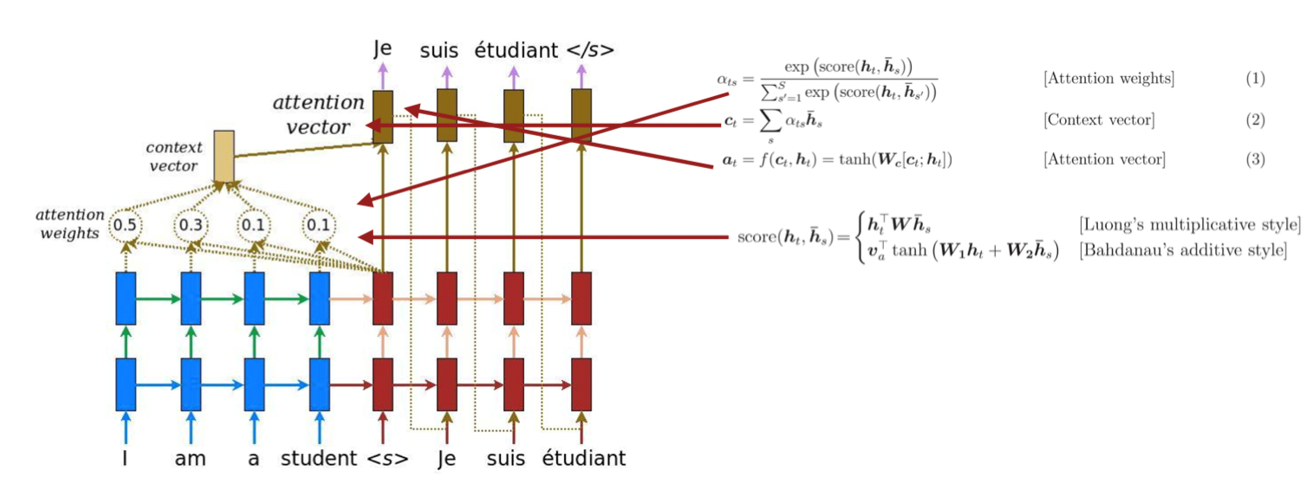

In [5]:
# 定义Attention机制
class BahdanauAttention(tf.keras.Model):

    # 定义初始化函数
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 初始化定义权重网络层W1, W2 以及最后的打分网络V，最终打分结果作为注意力的权重值
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    # 定义调用的函数，输入输出的逻辑变缓在这个函数中完成
    def call(self, query, values):
        # hidden shape = (batch_size, hidden size)
        # hidden_with_time_axis shape = (batch size, 1, hidden_size)
        # 计算attiong score
        hidden_with_time_axis = tf.expand_dims(query,1)
        # score的维度shi (batch size, maxlength, hidden_size)
        # 构建评价计算网络结构，受限计算W1和W2，然后将W1和W2的和 经过tanh进行非线性变缓，最后输入打分网络层
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        # attention_weights shape == (batch_size. maxlength, 1)
        # 计算attention_weights的值，我们使用softmax将score的值进行归一化，得到的是总和唯一的各个score值的概率分布
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector 文本向量的维度是(batch_size, hidden_size)
        # 将attention_weights的值与输入文本进行相乘，得到加权过的文本向量
        context_vector = attention_weights * values
        # 将上一步得到的文本向量按行求和，得到最终的文本向量
        context_vector = tf.reduce_sum(context_vector,axis=1)
        #  返回最终的文本向量和注意力权重
        return context_vector, attention_weights


In [6]:
# Decoder
class Decoder(tf.keras.Model):
    #
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        # 初始化批训练数据的大小
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # 初始化定义RNN结构，采用RNN的变种GRU结构
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")
        # 初始化定义全连接输出层
        self.fc = tf.keras.layers.Dense(vocab_size)
        # 使用Attention机制
        self.attention = BahdanauAttention(self.dec_units)

    # 定义调用函数，输入、输出的逻辑变换在这个函数中完成
    def call(self, x, hidden, enc_output):
        # 解码器输出的维度是（batch_size, maxlength, hidden_size）
        # 根据输入hidden和输出值使用Attention机制计算文本向量和注意力权重，hidden就是编码器输出的编码向量
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # 将x的维度在Embedding之后是(batch sizem ,1, embedding_dim)
        # 对解码器的输入进行Embedding处理
        x = self.embedding(x)
        # 将Embedding之后的向量和 经过Attention后的编码器输出的编码向量进行连接，然后作为输入向量输入到gru中
        x = tf.concat([tf.expand_dims(context_vector,1), x], axis=-1)
        # 将连接之后的编码向量输入gru中得到输出值和state
        output, state = self.gru(x)
        # 将输出的向量进行维度变换，变换成（batch_size, vocab）
        output = tf.reshape(output, (-1, output.shape[2]))
        # 将变换后的向量输入全连接网络中，得到最后的输出值
        outputs = self.fc(output)
        return outputs, state, attention_weights


In [7]:
# 对训练数据的字典大小进行初始化赋值
vocab_inp_size = gConfig['enc_vocab_size']
vocab_tar_size = gConfig['dec_vocab_size']
#对embedding的维度尽心初始化赋值
embedding_dim = gConfig['embedding_dim']
# 对网络层的神经元数量进行初始化赋值
units = gConfig['layer_size']

# 对批训练数据的大小进行初始化赋值
BATCH_SIZE = gConfig['batch_size']

# 实例化Encoder模型
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
# 实例化Attention模型
attention_layer = BahdanauAttention(10)
#实例化Decoder模型
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# 定义优化器
optimizer = tf.keras.optimizers.Adam()

# 定义整个模型的损失函数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [8]:
# 定义损失函数
def loss_function(real, pred):
    # dropout
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 计算损失向量
    loss_ = loss_object(real, pred)
    # 转换成mask向量的类型
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 使用mask向量对损失向量进行处理，去除Padding引入的噪声
    loss_ *= mask
    # 返回平均损失函数
    # 将损失函数转化为numpy
    return tf.reduce_mean(loss_)


# 实例化checkoint的方法类， 使用其中的save方法保存训练模型
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)


In [9]:

# 定义训练方法， 对输入的数据进行一次循环训练
def train_step(inp, targ, targ_lang, enc_hidden):
    loss = 0
    ## 使用tf,GraientTape记录梯度求导信息
    with tf.GradientTape() as tape:
        # 使用编码器对输入的语句进行编码，得到编码器的编码向量输出enc_output和中间层的输出enc_hidden
        enc_output, enc_hidden= encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        # 构建编码器输入向量，首词会用start对应的字典编码值作为向量的第一个数值，维度是BATCH_SIZE的大小，也就是一次批量训练的语句数量
        dec_input = tf.expand_dims([targ_lang.word_index['start']] * BATCH_SIZE, 1)
        # 开始训练编码器
        for t in range(1, targ.shape[1]):
            # 将构建的编码器输入向量和编码器输出对话中的上一句编码向量作为输入，输入到编码器中，训练解码器
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # 计算损失值
            loss += loss_function(targ[:,t], predictions)
            # 将对话中的下一句逐步分时作为编码器的输入，这相当于进行移位输入， 先从start标识开始， 逐步输入到对话中的下一句
            dec_input = tf.expand_dims(targ[:,t], 1)

        # 计算批处理的平均损失值
        batch_loss = (loss / int(targ.shape[1]))
        # 计算参数变量
        variables = encoder.trainable_variables + decoder.trainable_variables
        # 计算梯度
        gradients = tape.gradient(loss, variables)
        # 使用优化器优化参数变量的值，以达到拟合的效果
        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

##### 执行器

In [10]:
# -*- coding:utf-8 -*-
# 导入所需要的依赖包
import os, sys, time,  io
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pysnooper


In [11]:
# 为输入语句字典维度、输出语句字典维度、Embedding的维度、神经元的数量、批处理的大小赋值
vocab_inp_size = gConfig['enc_vocab_size']
vocab_tar_size = gConfig['dec_vocab_size']
#对embedding的维度尽心初始化赋值
embedding_dim = gConfig['embedding_dim']
# 对网络层的神经元数量进行初始化赋值
units = gConfig['layer_size']
# 对批训练数据的大小进行初始化赋值
BATCH_SIZE = gConfig['batch_size']

In [12]:
filepath = "D:/AI/project/pycharm/project4/train_data/seq_data"

In [13]:
# 定义一个语句处理函数， 在所有语句的开头和结尾分别加上start和end标识
def process_sentence(w):
    if w:
        w = '<start>' + w + '<end>'
    return w


# 定义一个训练数据集处理函数，其作用是读取文件中的数据，并进行初步的语句处理，在语句的前后加上开始和结束的标识
def create_dataset(path, num_examples):
    with open(path, 'r',encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    # 在读取数据的每句开头和结尾加上对应的表示
    word_pairs = [[process_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    # 返回处理好的数据
    inp, tar = [], []
    for pair in word_pairs:
        inp.append(pair[0])
        tar.append(pair[1])
    return tuple(inp), tuple(tar)


#定义一个函数计算最大的语句长度
def max_length(tensor):
    return max(len(t) for t in tensor)

# 定义word2vec的函数， 通过统计所有训练集中的字符出现频率，构建字典，并使用字典中的码值对训练集中的语句进行替换
def tokenize(lang):
    # 使用高阶API Tokenizer实例化一个转化器，构建字典并使用字典中的码值对训练集中的语句进行替换
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=gConfig['enc_vocab_size'], oov_token=3)
    lang_tokenizer.fit_on_texts(lang)
    # 转换器使用已经构建好的字典，将训练集的数据全部替换成字典的码值
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # 为了提高计算效率。将所有的语句长度同意补齐
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

# 定义数据加载的函数，可以根据需要按量加载数据
def load_dataset(path, num_examples):
    # 调用create_dataset创建数据集
    targ_lang, inp_lang = create_dataset(path=path, num_examples=num_examples)
    # 对数据集输入语句和输出语句进行word2vec转换
    input_tensor, input_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, input_lang_tokenizer, targ_lang_tokenizer

# 调用load_dataset函数，加载训练所需要的数据集
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path=filepath, num_examples=gConfig['max_train_data_size'])
# 计算训练集中的最大语句长度
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)


In [14]:
# 使用snoop装饰器帮助获取程序运行过程中的信息
#@pysnooper.snoop()
# 定义训练函数
def train():
    # 准备数据， 使用Train_test_split将训练集和验证集分开
    print("Preparing data in %s" % gConfig['train_data'])
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
    # 计算每个epoch循环需要多少步才能将所有数据训练一遍
    steps_per_epoch = len(input_tensor_train) // gConfig['batch_size']
    # 计算需要随机打乱排序的数据大小， 将数据集随机打乱可以防止模型过多先入局部最优解
    BUFFER_SIZE = len(input_tensor_train)
    # 将训练数据集随机打乱
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    # 批量获取数据
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    # 初始化模型保存路径
    checkpoint_dir = gConfig['model_data']
    # 初始化模型文件的保存前缀
    checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    # 获取当前开始训练的时间
    while True:
        #
        start_time_epoch = time.time()
        # 初始化隐藏层状态
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        # 批量从训练营中取出数据进行训练
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            # 获取每步训练得到的损失值
            batch_loss = train_step(inp, targ, targ_lang, enc_hidden)
            # 计算一个epoch的综合损失值
            total_loss += batch_loss
            # 计算每步训练索要消耗的时间
        step_time_epoch = (time.time() - start_time_epoch) / steps_per_epoch
        # 计算每步训练的loss
        step_loss = total_loss / steps_per_epoch
        # 计算当前已完成的训练步数
        current_steps =+ steps_per_epoch
        # 计算当前已经训练的步数每步的平均耗时
        step_time_total = (time.time() - start_time_epoch) / current_steps
        # 每一个epoch打印一下相关训练信息
        print("训练总步数：{} 每步耗时：{} 最新每步耗时：{} 最新每步loss值{:.4f}".format(current_steps, step_time_total, step_time_epoch, step_loss.numpy()))
        # 每一个epoch 保存一下模型文件
        checkpoint.save(file_prefix=checkpoint_prefix)
        # 刷新命令行输出
        sys.stdout.flush()


In [15]:
# 定义一个函数用于加载已经保存的模型
def reload_model():
    checkpoint_dir = gConfig['model_data']
    # 使用restore来加载最新的模型文件
    model = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    return model

#### prediction

In [16]:
pred_file_path = "D:\AI\project\pycharm\project4\model_data"
checkpoint_dir = pred_file_path
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
def predict(sentence):
    # 对输入语句进行处理，在语句的开头和结尾加上对应的标识
    sentence = process_sentence(sentence)
    # 对输入语句进行word2vec转换
    inputs = [inp_lang.word_index.get(i,3) for i in sentence.split(' ')]
    # 对输入语句按照最大长度补全
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    # 将输入转换为tensot
    inputs = tf.convert_to_tensor(inputs)
    # 初始化输出向量
    result = ''
    # 初始化隐藏层
    hidden = [tf.zeros((1, units))]
    # 对输入向量进行编码
    enc_out, enc_hidden = encoder(inputs, hidden)
    # 初始化解码器的隐藏层
    dec_hidden = enc_hidden
    # 初始化解码器的输入
    dec_input = tf.expand_dims([targ_lang.word_index['start']], 0)
    # 开始按照语句最大长度预测输出语句
    for t in range(max_length_targ):
        # 根据输入信息逐字对输出语句进行预测
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        # 使用argmax获取预测结果，argmax返回一个向量中的最大值的index
        prediction_id = tf.argmax(predictions[0]).numpy()
        # 通过查字典的方式，将预测的数值转换为词

        # 如果预测的结果是结束标识，则停止预测
        if targ_lang.index_word[prediction_id]  == "end":
            break
        result += targ_lang.index_word[prediction_id] + " "

        # 将预测的数值作为上文输入信息加入解码器中预测下一个
        dec_input = tf.expand_dims([prediction_id], 0)

    return result

In [30]:
import jieba
q = input("请输入您的问题：")
msg = " ".join(jieba.cut(q))
res_msg = predict(msg)
print(res_msg)

请输入您的问题：
你 的 


In [19]:
targ_lang.index_word[4]

'你'

In [34]:
BUFFER_SIZE = len(input_tensor)

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)

In [36]:
dataset

<DatasetV1Adapter shapes: ((396,), (43,)), types: (tf.int32, tf.int32)>

In [37]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [38]:
dataset

<DatasetV1Adapter shapes: ((32, 396), (32, 43)), types: (tf.int32, tf.int32)>

In [41]:
steps_per_epoch = len(input_tensor) // gConfig['batch_size']

In [44]:
312*32

9984